# Calculate 1/f decay between 20-100Hz of STN electrodes in On and Off condition

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne import io
from mne.time_frequency import psd_welch

from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.spectra import plot_spectrum
#%matplotlib qt

#### Create MNE Info

In [2]:
ch_names = ['SMA', 'leftM1', 'rightM1', 'STN_R01', 'STN_R12', 'STN_R23', 'STN_L01', 'STN_L12', 'STN_L23', 'EMG_R', 'EMG_L', 'HEOG', 'VEOG', 'event']
sfreq = 2400
ch_types = ["mag", "mag", "mag", "seeg", "seeg", "seeg", "seeg", "seeg", "seeg", "emg", "emg", "eog", "eog", "misc"]
info = mne.create_info(ch_names, sfreq, ch_types, verbose=True)

#### Load all subjects

In [3]:
%%capture
cond = "on"
raw_on = []

for i in range(1, 15):
    path = f'../../data/raw/rest/subj{i}/{cond}/'
    fname = os.listdir(path)[0]  # load first file only 
    raw_on.append(mne.io.read_raw_fieldtrip(path + fname, info, data_name='data'))

cond = "off"
raw_off = []

for i in range(1, 15):
    path = f'../../data/raw/rest/subj{i}/{cond}/'
    fname = os.listdir(path)[0]  # load first file only 
    raw_off.append(mne.io.read_raw_fieldtrip(path + fname, info, data_name='data'))

#### AC Notch Filter

In [4]:
#### Filter Parameters
filter_freqs = np.arange(50, 101, 50) # only 50Hz and 100Hz
notch_widths = .01 # gives best result
filter_window = "hann" # gives slightly better results than hamming

filter_params = {"freqs": filter_freqs, "notch_widths": notch_widths, "method": "fir", "filter_length": "auto",  "trans_bandwidth": 1,  "phase": "zero", "fir_window": filter_window, "fir_design": "firwin"}
filter_params = {"freqs": filter_freqs, "notch_widths": notch_widths, "fir_window": filter_window} # rest is default

In [5]:
%%capture
filtered_on = []
filtered_off = []

for raw in raw_on:
    filt = raw.copy().notch_filter(**filter_params)
    filtered_on.append(filt)

for raw in raw_off:
    filt = raw.copy().notch_filter(**filter_params)
    filtered_off.append(filt)

#### Compute Power Spectra using Welch's Method

In [6]:
#### Welch Parameters
n_per_seg1 = 1 * sfreq
n_per_seg2 = int(0.5 * sfreq)
fmin = 20 # we want spectrum from 20 Hz on
fmax = 99 # we want spectrum up to 100 Hz. 100 Hz excluded due to AC artefact
n_overlap = 0 # previously n_per_seg // 2 but makes no difference, defaults to 0
median = "median"
picks = "mag"

welch_params = {"fmin": 20, "fmax": fmax, "picks": picks, "n_overlap": n_overlap, "n_fft": n_per_seg2, "n_per_seg": None, "average": median}

In [7]:
%%capture
spectra_on = []
spectra_off = []

for data in filtered_on:
    spec, freqs = psd_welch(data, **welch_params)
    spectra_on.append(spec)

for data in filtered_off:
    spec, freqs = psd_welch(data, **welch_params)
    spectra_off.append(spec)

#### Compute Aperiodic Slope using fooof

In [17]:
#### fooof Parameters
freq_range = [20, 99] # "The E/I ratio will be measured with the slope of the broadband LFP spectrum at 20-100 Hz"
peak_width_limits = (4, 10) # for STN no big differences
peak_threshold = 1.8
aperiodic_mode="fixed" # knee much better than fixed! However, in Antrag it says "straight line"

fooof_params = {"peak_width_limits": peak_width_limits, "peak_threshold": peak_threshold, "aperiodic_mode": aperiodic_mode, "verbose": True}
fooof_params_fixed = {"peak_width_limits": peak_width_limits, "peak_threshold": peak_threshold, "aperiodic_mode": "fixed", "verbose": True}

fm = FOOOF(**fooof_params)

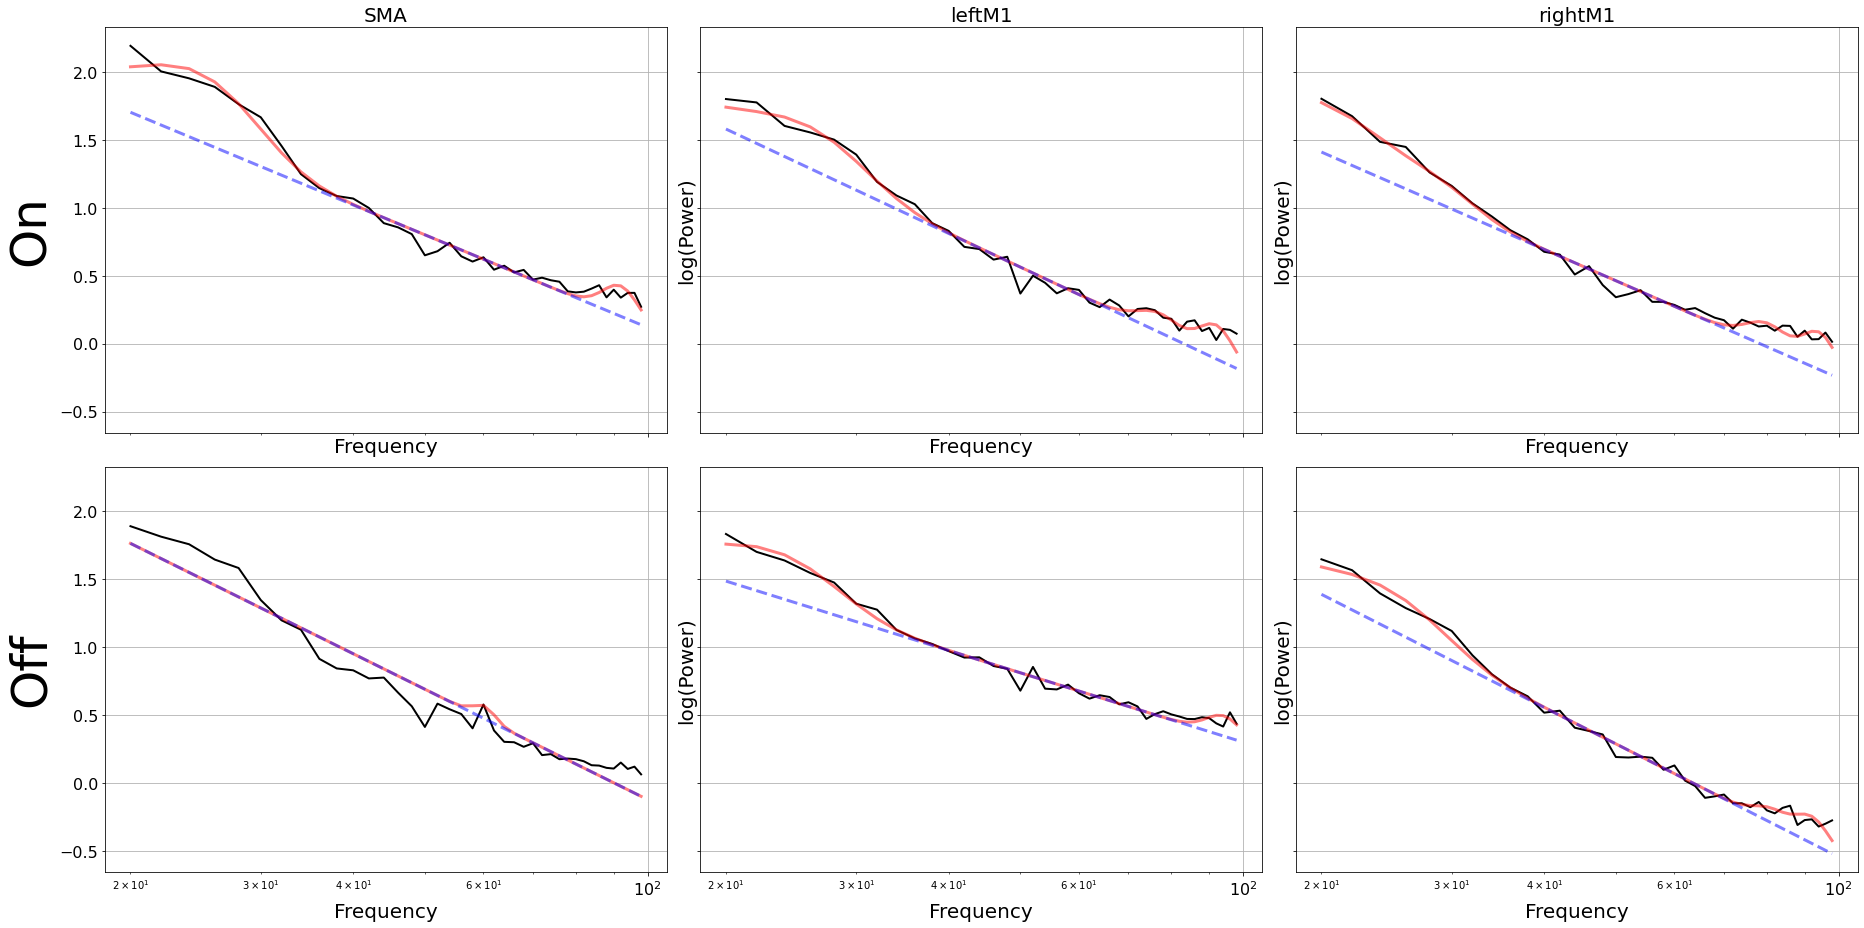

In [19]:
subject = 0 # 6 doesn't work

fm = FOOOF(**fooof_params)

n_elec = spectra_on[subject].shape[0]
n_cond = 2

fig, ax = plt.subplots(n_cond, n_elec, figsize=(26, 13), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(n_elec):
    fm.fit(freqs, spectra_on[subject][i], freq_range)
    fm.plot(ax=ax[i])
 #   fm.print_results()
    ax[i].get_legend().remove()
    ax[i].set_title(ch_names[i], fontsize=20)
    ax[i].set_xscale("log")
for i in range(n_elec):
    fm.fit(freqs, spectra_off[subject][i], freq_range)
    fm.plot(ax=ax[i+n_elec])
#    fm.print_results()
    if i < 5:
        ax[i+n_elec].get_legend().remove()
ax[0].set_ylabel("On", fontsize=50)
ax[3].set_ylabel("Off", fontsize=50)
plt.tight_layout()
plt.show()

#### Convert spectra list into numpy array

In [20]:
arr_on = np.vstack(spectra_on)
arr_off = np.vstack(spectra_off)

#### Aperiodic Beta Slope Exponent

Running FOOOFGroup across 42 power spectra.
Running FOOOFGroup across 42 power spectra.


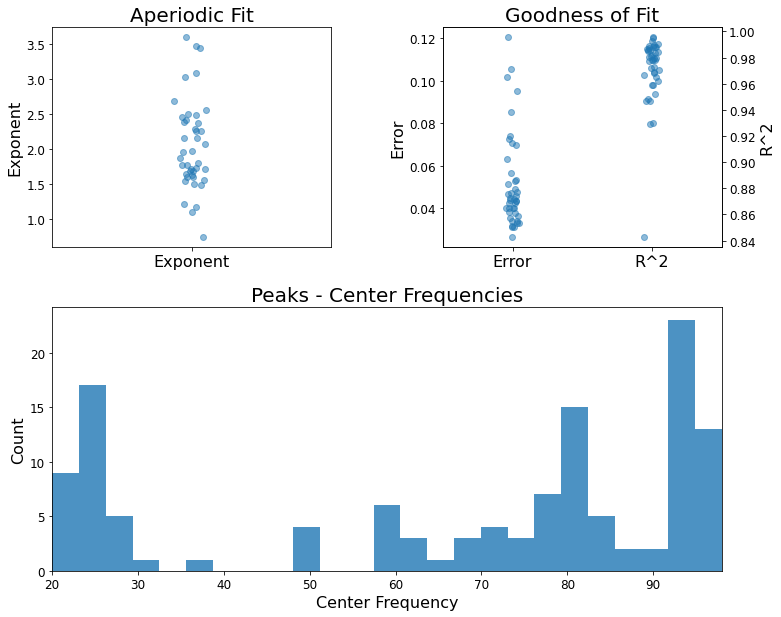

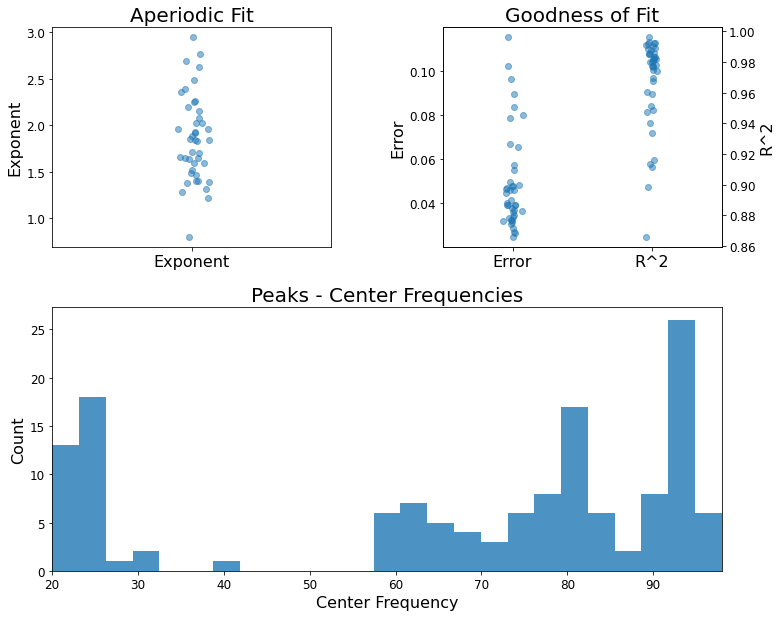

In [22]:
fg_on_ctx = FOOOFGroup(**fooof_params)
fg_on_ctx.fit(freqs, arr_on, freq_range)
fg_on_ctx.plot()

fg_off_ctx = FOOOFGroup(**fooof_params)
fg_off_ctx.fit(freqs, arr_off, freq_range)
fg_off_ctx.plot()

In [24]:
exp_on_ctx = fg_on_ctx.get_params('aperiodic_params', 'exponent')
exp_off_ctx = fg_off_ctx.get_params('aperiodic_params', 'exponent')

# eliminate nan values:
print(f"exp_on_stn contains {np.sum(np.isnan(exp_on_ctx))} nan values")
print(f"exp_off_stn contains {np.sum(np.isnan(exp_off_ctx))} nan values")
exp_on_ctx = exp_on_ctx[~np.isnan(exp_on_ctx)]
exp_off_ctx = exp_off_ctx[~np.isnan(exp_off_ctx)]

exp_on_stn contains 0 nan values
exp_off_stn contains 0 nan values


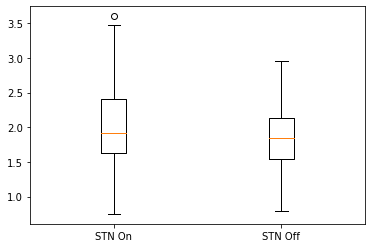

2.053847799234354 2.053847799234354


In [26]:
plt.figure()
plt.boxplot([exp_on_ctx, exp_off_ctx], labels=["STN On", "STN Off"])
plt.show()

print(np.mean(exp_on_ctx), np.mean(exp_on_ctx))

#### Save exponents for all subjects, conditions, elecrodes

In [28]:
n_subj = 14

on_exponent_knee = np.zeros([n_subj, n_elec])
off_exponent_knee = np.zeros([n_subj, n_elec])

on_exponent_fixed = np.zeros([n_subj, n_elec])
off_exponent_fixed = np.zeros([n_subj, n_elec])

In [29]:
for subj in range(n_subj):
 #   if subj == 6:
  #      nan = np.empty((6, ))
   #     nan[:] = np.NaN
    #    on_exponent_knee[subj] = nan
     #   on_exponent_fixed[subj] = nan
      #  off_exponent_knee[subj] = nan
       # off_exponent_fixed[subj] = nan
        #continue

    fm_f = FOOOFGroup(**fooof_params_fixed)
    fm_f.fit(freqs, spectra_on[subj], freq_range)
    exps_fixed = fm_f.get_params('aperiodic_params', 'exponent')
    on_exponent_fixed[subj] = exps_fixed

    fm_f = FOOOFGroup(**fooof_params_fixed)
    fm_f.fit(freqs, spectra_off[subj], freq_range)
    exps_fixed = fm_f.get_params('aperiodic_params', 'exponent')
    off_exponent_fixed[subj] = exps_fixed

Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOOOFGroup across 3 power spectra.
Running FOO

In [32]:
save_path = f'../../data/coherences/' 

np.save(save_path + "on_exponent_CTX", on_exponent_fixed, allow_pickle=True)
np.save(save_path + "off_exponent_CTX", off_exponent_fixed, allow_pickle=True)